# Satellite Derived Bathymetry Using a Tuned LightGBM Model for the Bahamas Area of Interest

Author: Gregor Beyerle

Date: 2022-06-19

## Overview

This notebook contains the steps taken to perform SDB estimations for the L2A, L1C, and Acolite data products for this AOI. This includes:

- Loading the prepared data
- Setting up training, validation and test data splits
- Performing hyper parameter and model tuning using Optuna
- Evaluating the model

In contrast to the Stumpf Log-Ratio Method which is based on empirical observations and evaluations tuning and fitting a LightGBM model for this use case is solely based on data driven methods.

In [1]:
import os
import sys
import dotenv

from IPython.utils import io

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.ml_tools import TrainTestSplitTask

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import log_evaluation, early_stopping
import optuna.integration.lightgbm as lgb
import dalex as dx

This notebook uses functionality of both the `eolearn_extras` module as well as the `sdb_utils` module. It is important to add the relative location of the repository's root directory to the `sys.path` and import `eolearn_extras` before `sdb_utils` as some functions in this module reference `eolearn_extras`.

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
    get_masked_map,
    create_train_val_set,
    write_optuna_capture_to_logs,
)

The data for this project can - depending on whether you work with the complete dataset or only the preprocessed data - be roughly 13 GB on disk. This makes it necessary to distribute data individually from the repository and therefore the location of the data root directory might differ from setup to setup. This repository uses a `.env` file to configure the individual data root directory location. You need to add the `.env` file to your `notebooks` directory and add a line containing the needed information as a line following the pattern `data_root=<path-to-your-data-root>` in order for this notebook to work correctly.

In [3]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

We already prepared the needed data for this AOI in previous notebooks. The first step of the workflow for preparing the train-test-split is to load it from disk.

In [4]:
bahamas_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_sentinel_merged')
)
load_bahamas_eop = LoadTask(bahamas_eop_path)

The eo-learn framework includes a `TrainTestSplitTask` which can be used to create a mask with an arbitrary amount of numerical class (e.g. train, validation and test) labels. For this AOI I decided to use 5% of all possible pixels for training and validation, holding back 95% of the remaining pixels for the final evaluation. I did not want to use more samples because with the AOI not offering a very high degree of variance and the spatial resolution being relatively high, the danger of overfitting appears to be especially pressing. Also, even if in reality a field survey is unlikely to perform a uniform sampling over the whole AOI, I would like to perform an analysis that has some use for people that only have the possibility to survey a limited amount of point tracks when collecting their own calibration data.

In [5]:
data_mask_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_mask_feature,
    output_feature=train_test_mask_feature,
    bins=[0.025, 0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

The `TrainTestSplitTask` does not itself take an argument for masking out "uninteresting" pixels. Also, it does produce only one mask for all classes, which is - at times - cumbersome to use. I use the `AddValidTrainTestMasks` to combine the bathymetry data mask and the pixel locations of each split to their own masks.

In [6]:
valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_mask_feature
)

The workflow for performing this preparation is comparatively simple as seen in the dependency graph below.

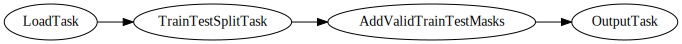

In [7]:
tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_bahamas_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task,
)
read_merge_wf = EOWorkflow(nodes)

read_merge_wf.dependency_graph()

Without configuring a random seed to the `TrainTestSplitTask` the pixels in each split would differ with each execution. While this should not impact the analysis it would impair others to repeat the analysis and come to the exact same results. The `seed` argument has to be configured at execution time. To do this in the context of a workflow rather than a simple task execution we can find the `EONode` reference in the list of nodes which was implicitly created for us when we executed the `linearly_connected_tasks` function.

After executing the workflow we can see that we now have the required masks as well as some additional information in the `meta_info` that helps to gain an intuition for the magnitude of each supported split.

In [8]:
train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 894, 1946, 13), dtype=float32)
    L2A_data: numpy.ndarray(shape=(1, 894, 1946, 12), dtype=float32)
    L2W_data: numpy.ndarray(shape=(1, 894, 1946, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(894, 1946, 1), dtype=float64)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(894, 1946, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(894, 1946, 1), dtype=int64)
    validation_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
  }
  meta_info={
    test_count: 1653194
    test_perc: 0.950262225502436
    train_count: 43427
    train_perc: 0.02496200546753393
    validation_count: 43103
    validation_perc: 0.02477576903003005
  }
  bbox=BBox(((758523.8845987623, 2793786.7214435483), (777983.8845987623, 2802726.7214435483)), 

To get a better idea how the samples are distributed per split we can have a look at the created maps. Below we can see the split for training data as an example.

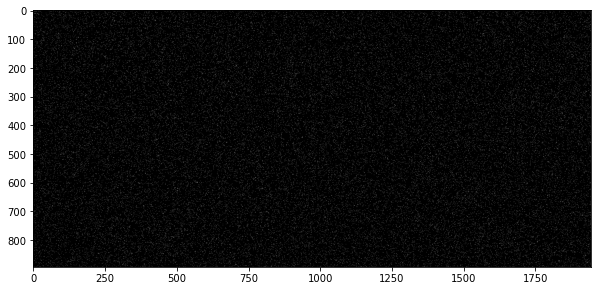

In [9]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False, stretch=False)
plt.show()

## Performing SDB on the Basis of L2A Data

In contrast to the empirical Stumpf Log-Ratio model where we can follow an intuitive formula to prepare the most significant band information and use that to fit a linear regression model without any hyper parameters, there are more elements to calibrate in a regression problem when using LightGBM. LightGBM is a machine learning library that allows us to build models on the basis of gradient boosted trees. On this basis we can model non-linear relationships and effects between different attributes while also working with large amount of data (Ke et al., 2017). To get the best results I plan to use the Optuna hyperparameter optimization framework (Akiba et al., 2019) to choose the best combination of hyper parameters for a given AOI.

LightGBM works best with `DataSet` objects that allow very efficient access for training a large amount of decision trees.

In [10]:
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2A_data'))

I use the `optuna.integration.lightgbm` module as a drop-in replacement for the standard LightGBM python model. This has the positive effect of full Optuna integration while still being very close to the standard LightGBM API.

I configure the model for a regression task using the mean squared error as the the error metric. I set a random seed because LightGBM uses randomness in the process of building the gradient boosted trees and I would like to deterministically produce the same results for each time this experiment is rerun.

In theory a LightGBM model could train for an arbitrarily large amount of iterations. When doing that on a training data set the results will - with enough time - most likely approach optimal scores for this exact set of data, leading to sever overfitting. I configure an early stopping callback that stops the training of a model if there hasn't been any improvement on the validation data set (improvements in the training data set get ignored) for 100 iterations.

As Optuna and LightGBM can get rather verbose with their outputs I configure a Jupyter Notebook capture to which a large amount of outputs that might still be interesting for debugging are sent.

In [11]:
params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'seed': 42,
}

with io.capture_output() as capture:
    model_l2a = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-06-20 03:58:31,197] A new study created in memory with name: no-name-a5f5e421-320b-40af-b81d-406aed45dfb9
[I 2022-06-20 03:58:35,571] Trial 0 finished with value: 0.012528282077987495 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.012528282077987495.
[I 2022-06-20 03:58:39,070] Trial 1 finished with value: 0.012528282077987495 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.012528282077987495.
[I 2022-06-20 03:58:43,009] Trial 2 finished with value: 0.012528282077987495 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.012528282077987495.
[I 2022-06-20 03:58:46,778] Trial 3 finished with value: 0.012528282077987495 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.012528282077987495.
[I 2022-06-20 03:58:52,264] Trial 4 finished with value: 0.012528282077987495 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.012528282077987495.
[I 2022-06-20 03

After the optimization process we can extract the parameters for the Optuna study. The Optuna LightGBM integration is configured to tune the `lambda_l1`, `lambda_l2`, `num_leaves`, `feature_fraction`, `bagging_fraction` and `bagging_freq` parameters of the model using a Tree-structured Parzen Estimator (TPE) sampling algorithm. I set a fixed random seed for this process because the `TPESampler` is based on probabilistic models and therefore can produce different results for each study run (Akiba et al., 2019).

In [12]:
best_params = model_l2a.params
best_params

{'objective': 'regression',
 'metric': 'l2',
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0009779587236218158,
 'lambda_l2': 0.1706087547564104,
 'num_leaves': 252,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 25,
 'num_iterations': 1000,
 'early_stopping_round': None}

As we are estimating pixel values for a bathymetry map we can generate estimates for the whole map to visualize the model output. In the below cell we retrieve all valid explanatory data to produce a completely estimated map. For the Bahamas AOI we were able to achieve a very close approximation of the actual bathymetry map with some loss of detail and some visual artifacts that were also present in the estimation generated with the Stumpf model but not in the ground truth data (e.g. the ridge line formed like a quarter circle segment from the middle of the image leading into the direction of the lower right corner).

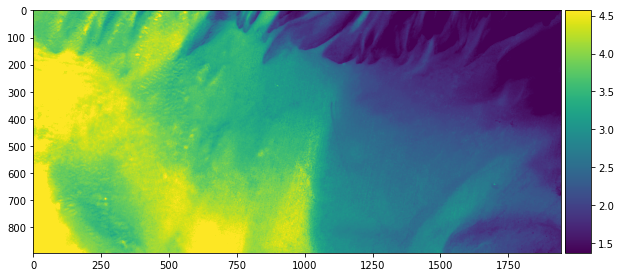

In [13]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, model_l2a, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

For the Bahamas AOI the map showing the deviations from the ground truth data differs from its Stumpf counterpart by having less areas that indicate loss of ground structure information while appearing far noisier.

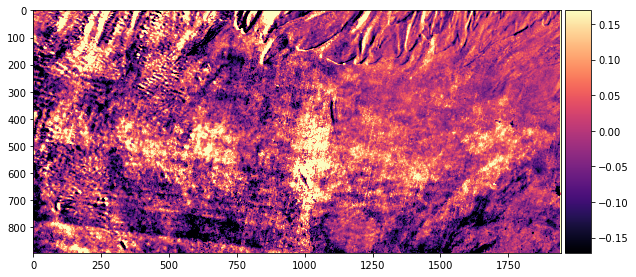

In [14]:
masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l2a_sdb_errors = l2a_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

From the distribution of residuals we can see a narrower, more symmetric picture than we would in the Stumpf example. We can also observe that the distribution appears to be denser in the region of smaller deviations.

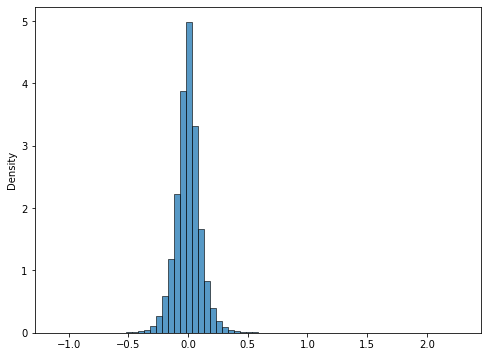

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.05, stat='density', ax=ax)
plt.show()

One of the more obvious drawbacks of using a tuned LightGBM model is that it is harder to reason about it. The regression metrics show impressive improvements over the Stumpf model but in contrast to a linear regression which can be easily interpreted and statistically tested for validity we have to use other methods for further inspection. At the end of this notebook I will use the dalex framework (Baniecki et al., 2021) for a brief exploration.

In [16]:
exp_lgbm_l2a = dx.Explainer(model_l2a, val_ds.data, val_ds.label, label='lgbm_tuned_l2a', verbose=False)
exp_lgbm_l2a.model_performance()

,mse,rmse,r2,mae,mad
lgbm_tuned_l2a,0.012333,0.111056,0.988641,0.078241,0.057226


## Performing SDB on the Basis of L1C Data

After performing the analysis on the basis of the L2A dataset we can now tune a model on the basis of the alternative data extracted from the L1C product. As the process remains mostly the same with the difference that we are using a different set of values for the training data set I will omit the explanation of the details as well as the discussion of the results until we reach the comparative evaluation.

In [17]:
# retrieve L1C training and validation data sets
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L1C_data'))

# tune lgbm model for L1C data
with io.capture_output() as capture:
    model_l1c = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

# retrieve L1C complete input and label data
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

# estimate L1C SDB values for complete data set
l1c_sdb_estimation_values, _ = create_sdb_estimation(train_test_eop, model_l1c, X_all)

# compute residuals for complete data set
l1c_sdb_residuals = l1c_sdb_estimation_values - y_all

# prepare explainer for L1C model on the complete data set
exp_lgbm_l1c = dx.Explainer(model_l1c, X_all, y_all, label='lgbm_tuned_l1c', verbose=False)

[I 2022-06-20 04:06:12,475] A new study created in memory with name: no-name-d38ea256-df27-4bca-bbe8-5f19ac71e9b1
[I 2022-06-20 04:06:14,569] Trial 0 finished with value: 0.010156489854346277 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.010156489854346277.
[I 2022-06-20 04:06:16,708] Trial 1 finished with value: 0.010075773208517337 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.010075773208517337.
[I 2022-06-20 04:06:18,862] Trial 2 finished with value: 0.010009634035520501 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.010009634035520501.
[I 2022-06-20 04:06:20,516] Trial 3 finished with value: 0.010009634035520501 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.010009634035520501.
[I 2022-06-20 04:06:22,622] Trial 4 finished with value: 0.010009634035520501 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.010009634035520501.
[I 2022-06-20 04

## Performing SDB on the Basis of Acolite Data

After performing the analysis on the basis of the L2A and L1C datasets we can now tune a model on the basis of the alternative data extracted from the Acolite product. As the process remains mostly the same with the difference that we are using a different set of values for the training data set I will omit the explanation of the details as well as the discussion of the results until we reach the comparative evaluation.

In [18]:
# retrieve Acolite training and validation data sets
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2W_data'))

# tune lgbm model for Acolite data
with io.capture_output() as capture:
    model_acolite = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

# retrieve Acolite complete input and label data
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2W_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

# estimate Acolite SDB values for complete data set
acolite_sdb_estimation_values, _ = create_sdb_estimation(train_test_eop, model_acolite, X_all)

# compute residuals for complete data set
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all

# prepare explainer for Acolite model on the complete data set
exp_lgbm_acolite = dx.Explainer(model_acolite, X_all, y_all, label='lgbm_tuned_acolite', verbose=False)

[I 2022-06-20 04:08:45,855] A new study created in memory with name: no-name-7b0724f7-18ed-4d73-9ec0-72e9854aa19e
[I 2022-06-20 04:08:47,942] Trial 0 finished with value: 0.011816734214874329 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.011816734214874329.
[I 2022-06-20 04:08:49,765] Trial 1 finished with value: 0.011724983837615348 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.011724983837615348.
[I 2022-06-20 04:08:51,572] Trial 2 finished with value: 0.011724983837615348 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.011724983837615348.
[I 2022-06-20 04:08:53,264] Trial 3 finished with value: 0.011686227316284367 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.011686227316284367.
[I 2022-06-20 04:08:55,424] Trial 4 finished with value: 0.011686227316284367 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.011686227316284367.
[I 2022-06-20 04:08:57,057] Tri

## Evaluation of SDB Results

Looking at the raw performance metrics we see that all models are almost equally good with an RMSE of roughly 10 centimeters and a $R^2$ approaching 99%. While the Bahamas AOI is relatively shallow and has very clear water metrics indicating this grade of estimation fidelity could indicate overfitting for this area.

In [19]:
exp_list = [exp_lgbm_l1c, exp_lgbm_l2a, exp_lgbm_acolite]
pd.concat([exp.model_performance().result for exp in exp_list])

,mse,rmse,r2,mae,mad
lgbm_tuned_l1c,0.009903,0.099514,0.990895,0.068260,0.049120
lgbm_tuned_l2a,0.012333,0.111056,0.988641,0.078241,0.057226
lgbm_tuned_acolite,0.011519,0.107325,0.989410,0.072340,0.051177


Overlaying the residuals confirms that there is very little difference in the performance of the individual models.

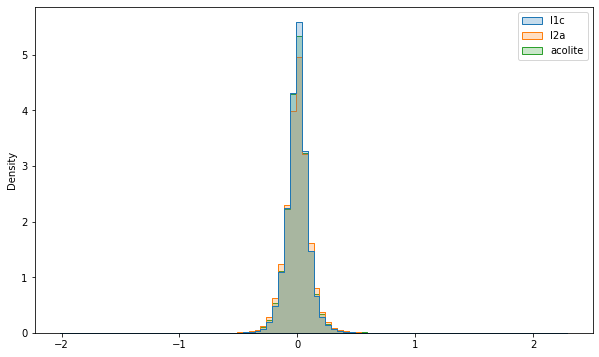

In [20]:
residuals_df = pd.DataFrame({
    'l1c': l1c_sdb_residuals,
    'l2a': l2a_sdb_residuals,
    'acolite': acolite_sdb_residuals
})

plt.figure(figsize=(10, 6))
sns.histplot(residuals_df, binwidth=0.05, stat='density', element='step', common_norm=False)
plt.show()

In [ ]:
exp_list[0].model_parts().plot([exp.model_parts() for exp in exp_list[1:]])

![variable importance plot](../figures/plotly_exports/11__variable_importance.png)